In [39]:
import gym
import math
import random
import time
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim

seed_value = 42
torch.manual_seed(seed_value)
random.seed(seed_value)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


*** Episode 0 ***                       
Av.reward: [last 10]: 2.50, [last 100]: 0.25, [all]: 25.00                       
epsilon: 0.86, frames_total: 25
Elapsed time:  00:00:00

*** Episode 10 ***                       
Av.reward: [last 10]: 30.30, [last 100]: 3.28, [all]: 29.82                       
epsilon: 0.48, frames_total: 328
Elapsed time:  00:00:00

*** Episode 20 ***                       
Av.reward: [last 10]: 19.50, [last 100]: 5.23, [all]: 24.90                       
epsilon: 0.33, frames_total: 523
Elapsed time:  00:00:00

*** Episode 30 ***                       
Av.reward: [last 10]: 38.80, [last 100]: 9.11, [all]: 29.39                       
epsilon: 0.16, frames_total: 911
Elapsed time:  00:00:00

*** Episode 40 ***                       
Av.reward: [last 10]: 49.10, [last 100]: 14.02, [all]: 34.20                       
epsilon: 0.07, frames_total: 1402
Elapsed time:  00:00:00

*** Episode 50 ***                       
Av.reward: [last 10]: 42.00, [last 100]: 18


*** Episode 440 ***                       
Av.reward: [last 10]: 500.00, [last 100]: 358.96, [all]: 278.93                       
epsilon: 0.02, frames_total: 123010
Elapsed time:  00:01:28

*** Episode 450 ***                       
Av.reward: [last 10]: 222.80, [last 100]: 344.28, [all]: 277.69                       
epsilon: 0.02, frames_total: 125238
Elapsed time:  00:01:29

*** Episode 460 ***                       
Av.reward: [last 10]: 500.00, [last 100]: 344.28, [all]: 282.51                       
epsilon: 0.02, frames_total: 130238
Elapsed time:  00:01:33

*** Episode 470 ***                       
Av.reward: [last 10]: 500.00, [last 100]: 371.23, [all]: 287.13                       
epsilon: 0.02, frames_total: 135238
Elapsed time:  00:01:36

*** Episode 480 ***                       
Av.reward: [last 10]: 310.00, [last 100]: 352.23, [all]: 287.60                       
epsilon: 0.02, frames_total: 138338
Elapsed time:  00:01:38

*** Episode 490 ***                       
A

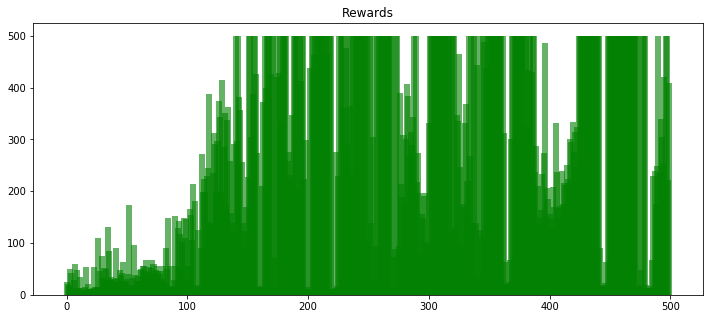

In [43]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.Tensor

env = gym.make('CartPole-v1')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

###### PARAMS ######
learning_rate = 0.01
num_episodes = 500
gamma = 0.99

hidden_layer = 64

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

report_interval = 10
score_to_solve = 195

####################

number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer)
        self.linear2 = nn.Linear(hidden_layer,number_of_outputs)

        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)

        return output2
    
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)

        self.loss_func = nn.MSELoss()
        #self.loss_func = nn.SmoothL1Loss()
        
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        #self.optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():
                
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        
        reward = Tensor([reward]).to(device)
        
        if done:
            target_value = reward
        else:
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
        
        predicted_value = self.nn(state)[action]
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        #Q[state, action] = reward + gamma * torch.max(Q[new_state])

        
        


qnet_agent = QNet_Agent()

steps_total = []

frames_total = 0 
solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    step = 0
    #for step in range(100):
    while True:
        
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        #action = env.action_space.sample()
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)

        qnet_agent.optimize(state, action, new_state, reward, done )
        
        state = new_state
        
        if done:
            steps_total.append(step)
            
            mean_reward_100 = sum(steps_total[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % report_interval == 0):
                
                
                
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, frames_total: %i" 
                  % 
                  ( i_episode,
                    report_interval,
                    sum(steps_total[-report_interval:])/report_interval,
                    mean_reward_100,
                    sum(steps_total)/len(steps_total),
                    epsilon,
                    frames_total
                          ) 
                  )
                  
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))



            break
        

print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
if solved:
    print("Solved after %i episodes" % solved_after)
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green', width=5)
plt.show()

env.close()
env.env.close()


In [ ]:
# Close env
env.close()
env.env.close()